In [5]:
%env DDE_BACKEND=tensorflow
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


env: DDE_BACKEND=tensorflow


Compiling model...
'compile' took 0.000589 s

Training model...



c:\Users\Matuchaki\AppData\Local\pypoetry\Cache\virtualenvs\deepxde-custom-E_cFIhQu-py3.10\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Cause: could not parse the source code of <function <lambda> at 0x000002062950C280>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000002062950C280>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000002062950C5E0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x0000020629

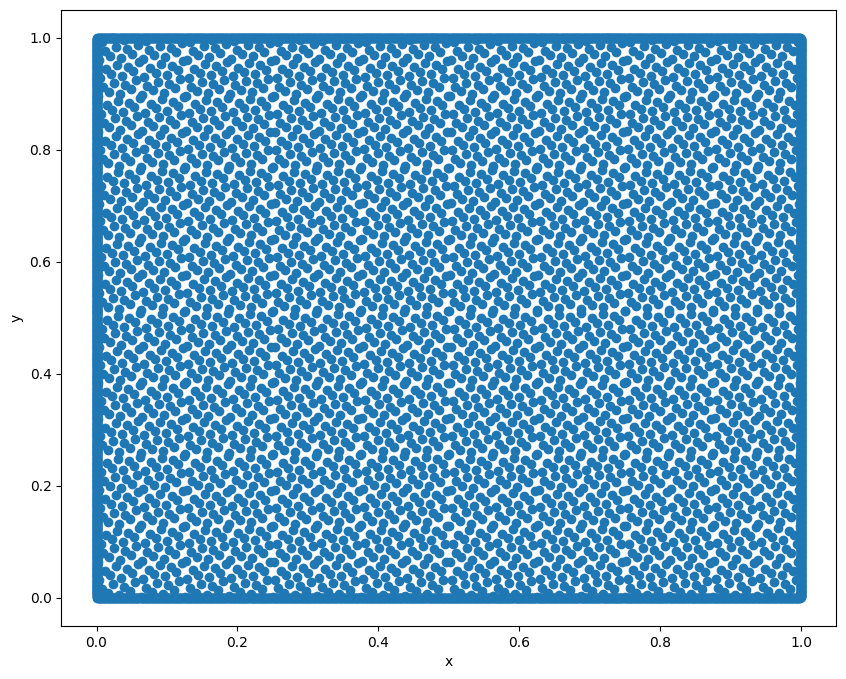

In [2]:
a = 1
b = 1
q = 5.0
k = 0.5

geom = dde.geometry.Rectangle(xmin=[0, 0], xmax=[a, b])  # (Altura e Largura)

def boundary_bottom(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0., rtol=1e-05, atol=1e-08) and not (np.isclose(x[0], 0., rtol=1e-05, atol=1e-08) or np.isclose(x[0], a, rtol=1e-05, atol=1e-08))

def boundary_top(x, on_boundary):
    return on_boundary and np.isclose(x[1], b, rtol=1e-05, atol=1e-08) and not (np.isclose(x[0], 0., rtol=1e-05, atol=1e-08) or np.isclose(x[0], a, rtol=1e-05, atol=1e-08))

def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0., rtol=1e-05, atol=1e-08) and not (np.isclose(x[1], 0., rtol=1e-05, atol=1e-08) or np.isclose(x[1], b, rtol=1e-05, atol=1e-08))

def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], a, rtol=1e-05, atol=1e-08) and not (np.isclose(x[1], 0., rtol=1e-05, atol=1e-08) or np.isclose(x[1], b, rtol=1e-05, atol=1e-08))

def boundary_vertices(x, on_boundary):
    return on_boundary and (np.isclose(x[0], 0., rtol=1e-05, atol=1e-08) and np.isclose(x[1], 0., rtol=1e-05, atol=1e-08) or 
                            np.isclose(x[0], a, rtol=1e-05, atol=1e-08) and np.isclose(x[1], 0., rtol=1e-05, atol=1e-08) or 
                            np.isclose(x[0], 0., rtol=1e-05, atol=1e-08) and np.isclose(x[1], b, rtol=1e-05, atol=1e-08) or 
                            np.isclose(x[0], a, rtol=1e-05, atol=1e-08) and np.isclose(x[1], b, rtol=1e-05, atol=1e-08))

ux_top_bc = dde.icbc.DirichletBC(geom, lambda x: 0., boundary_top)
ux_bottom_bc = dde.icbc.DirichletBC(geom, lambda x: 0., boundary_bottom)
uy_left_bc = dde.icbc.DirichletBC(geom, lambda x: 0., boundary_left)
bc_yn = dde.icbc.NeumannBC(geom, lambda x: q / k, boundary_right)
bc_vertices = dde.icbc.DirichletBC(geom, lambda x: 0., boundary_vertices)

def pde(x, y):
    du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    pde_laplace = du_yy + du_xx
    return pde_laplace

data = dde.data.PDE(
    geom,
    pde,
    [ux_top_bc, ux_bottom_bc, uy_left_bc, bc_yn, bc_vertices],
    num_domain=4000,
    num_boundary=4000,
)

# Excluir vértices explicitamente
vertices = np.array([[0., 0], [a, 0.], [0., b], [a, b]])
mask = ~np.isin(data.train_x_all, vertices).all(axis=1)
data.train_x_all = data.train_x_all[mask]

plt.figure(figsize=(10, 8))
plt.scatter(data.train_x_all[:, 0], data.train_x_all[:, 1])
plt.xlabel('x')
plt.ylabel('y')

net = dde.nn.FNN([2] + 5 * [64] + [1], "tanh", "Glorot normal")

model = dde.Model(data, net)

model.compile("adam", lr=0.001, metrics=["accuracy"])
losshistory, train_state = model.train(epochs=5000, display_every=100)
dde.optimizers.config.set_LBFGS_options(maxiter=3000)
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=False, isplot=False)

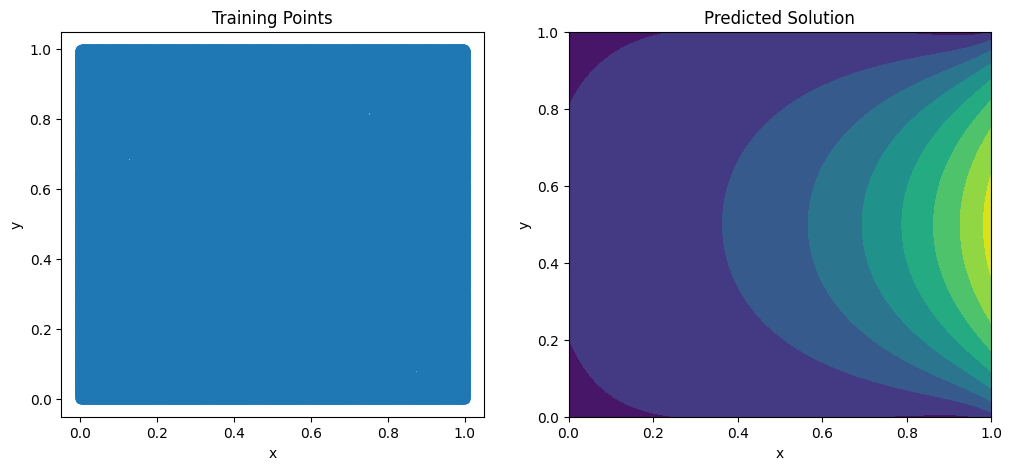

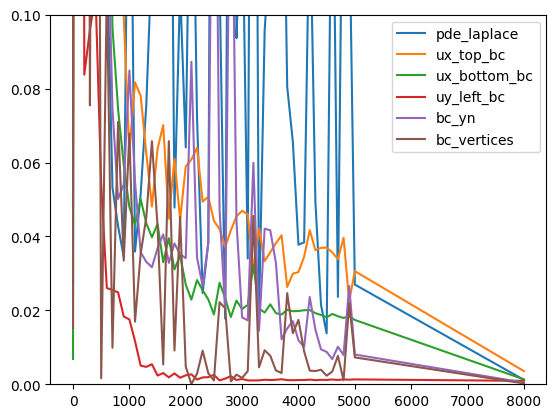

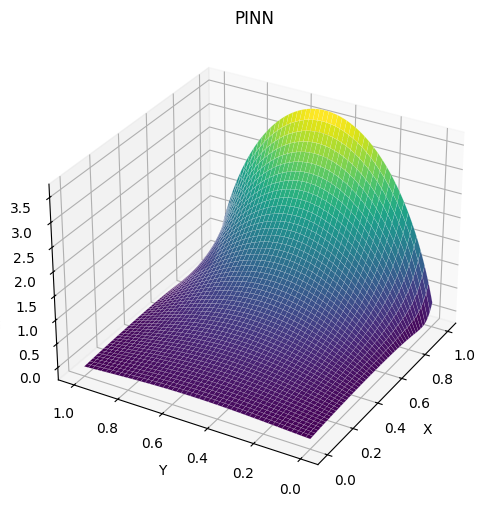

In [10]:
# Visualize the solution
x_data = np.linspace(0, a, 1000)
y_data = np.linspace(0, b, 1000)
X, Y = np.meshgrid(x_data, y_data)
XY = np.column_stack([X.flatten(), Y.flatten()])
u_pred = model.predict(XY)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(data.train_x_all[:, 0], data.train_x_all[:, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training Points')

plt.subplot(1, 2, 2)
plt.contourf(X, Y, u_pred.reshape(X.shape), cmap='viridis')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted Solution')
plt.show()

plot_array = np.array(losshistory.loss_test)
plot_labels = ["pde_laplace", "ux_top_bc", "ux_bottom_bc", "uy_left_bc", "bc_yn", "bc_vertices"]
# plot_array = np.array(losshistory.loss_train)
for i in range(plot_array.shape[1]):
    plt.plot(losshistory.steps, plot_array[:,i], label=plot_labels[i])
    
plt.legend()
plt.ylim([0, 0.1])
plt.show()

# Plot 3D surface
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, u_pred.reshape(X.shape), cmap='viridis', edgecolor='w', linewidth=0.07)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Temperature')
ax.set_title('PINN')
ax.view_init(elev=30, azim=210)  # Adjusting the elevation and azimuth angle
plt.show()

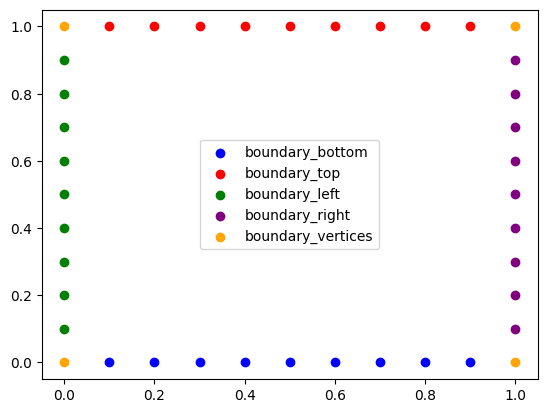

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def boundary_bottom(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0., rtol=1e-05, atol=1e-08) and not (np.isclose(x[0], 0., rtol=1e-05, atol=1e-08) or np.isclose(x[0], a, rtol=1e-05, atol=1e-08))

def boundary_top(x, on_boundary):
    return on_boundary and np.isclose(x[1], b, rtol=1e-05, atol=1e-08) and not (np.isclose(x[0], 0., rtol=1e-05, atol=1e-08) or np.isclose(x[0], a, rtol=1e-05, atol=1e-08))

def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0., rtol=1e-05, atol=1e-08) and not (np.isclose(x[1], 0., rtol=1e-05, atol=1e-08) or np.isclose(x[1], b, rtol=1e-05, atol=1e-08))

def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], a, rtol=1e-05, atol=1e-08) and not (np.isclose(x[1], 0., rtol=1e-05, atol=1e-08) or np.isclose(x[1], b, rtol=1e-05, atol=1e-08))

def boundary_vertices(x, on_boundary):
    return on_boundary and (
        (np.isclose(x[0], 0., rtol=1e-05, atol=1e-08) and np.isclose(x[1], 0., rtol=1e-05, atol=1e-08)) or 
        (np.isclose(x[0], a, rtol=1e-05, atol=1e-08) and np.isclose(x[1], 0., rtol=1e-05, atol=1e-08)) or 
        (np.isclose(x[0], 0., rtol=1e-05, atol=1e-08) and np.isclose(x[1], b, rtol=1e-05, atol=1e-08)) or 
        (np.isclose(x[0], a, rtol=1e-05, atol=1e-08) and np.isclose(x[1], b, rtol=1e-05, atol=1e-08))
    )


# Função para visualizar a malha
def plot_mesh(points, boundary_funcs):
    for func, color in boundary_funcs:
        boundary_points = [point for point in points if func(point, True)]
        x, y = zip(*boundary_points)
        plt.scatter(x, y, color=color, label=func.__name__)
    
    plt.legend()
    plt.show()

# Gerar pontos para teste
points = np.array([[i/10, j/10] for i in range(11) for j in range(11)])

# Funções de contorno e cores
boundary_funcs = [
    (boundary_bottom, 'blue'),
    (boundary_top, 'red'),
    (boundary_left, 'green'),
    (boundary_right, 'purple'),
    (boundary_vertices, 'orange')
]

# Plotar a malha
plot_mesh(points, boundary_funcs)
